In [1]:
%matplotlib inline
%run ./bella/bellamodel/parse.py
bp = BellaParse()
%run ./bella/bellamodel/search.py
bs = BellaSearch()
import warnings
warnings.filterwarnings('ignore')

In [13]:
cd /Users/Nan/insight/bella/

/Users/Nan/insight/bella


In [20]:
fp='./bella/bellascraper/bellascraper/data/review_serum.tsv'
reviews_short = bp.parse_reviewTable(fp, products='all')
#remove I used, I want sentences, non-informative
#sense_reviews = bp.remove_nonsense(reviews_short['review'].values, 
#                                   nonsense_sample=bp.nonsense_samples)

In [22]:
reviews_short['senti_score'] = reviews_short['review'].apply(bs.sentiment)

In [24]:
reviews_short.to_csv('./bella/bellascraper/bellascraper/data/review_sentiment.tsv', 
                          sep='\t', index=False)

In [8]:
#remove neutral reviews to save time in feature score calculation
df = reviews_short[reviews_short['senti_score'] != 0]
df = df.drop_duplicates(subset=['review', 'r_product'])
fp = './bella/bellaflask/tmp/review_sentiment.df.pk'
with open(fp, 'wb') as f:
    pickle.dump(df, f)

In [9]:
#correct misspelling
#stop as it took too long
#df['review'] = map(lambda s: TextBlob(s).correct(), df['review'].values)

In [7]:
#save concise version of review dataframe for web app
df['review'] = df['review'].apply(bp.wordToken)
df['n_word'] = df['review'].apply(len)
df = df[df['n_word'] > 2]
df = df.drop(['n_word'], axis=1)
filename = './bella/bellaflask/tmp/review_sentiment.df.pk'
with open(filename, 'wb') as f:
     pickle.dump(df, f)

In [50]:
#Calculate manual reading time
#average reading speed of normal human being 200 words/minute (http://www.readingsoft.com/)
reviews_short['n_word'] = reviews_short['review'].apply(lambda t: len(t.split(' ')))
reviews_short['n_word'].sum()/200

33341

In [10]:
#remove non-ascii, correct spelling, remove stop word, stemming, lemmitize, normalize
#clean_reviews = map(bp.clean, reviews_short['review'].values)
#use clean reviews, roots cannot match with user's input

In [15]:
#train word2vec with sephora reviews
token_reviews = map(gensim.utils.simple_preprocess, reviews_short['review'].values)
w2v, w2v_volcab, w2v_vectors = bs.w2v_model(token_reviews, size=150, window=10)
w2v.wv.most_similar(positive='wrinkle')

[(u'ageing', 0.5884653329849243),
 (u'polyphenol', 0.5307056903839111),
 (u'crease', 0.5097635984420776),
 (u'aging', 0.5093438625335693),
 (u'elevens', 0.5073592066764832),
 (u'broad', 0.5029598474502563),
 (u'oxidants', 0.46808359026908875),
 (u'neuropeptide', 0.46676844358444214),
 (u'spectrum', 0.465499609708786),
 (u'ager', 0.4490583539009094)]

In [25]:
w2v.save("word2vec.model")

In [20]:
#save word2vec model
filename = './bella/bellaflask/tmp/word2vec.pk'
with open(filename, 'wb') as f:
     pickle.dump(w2v, f)

In [18]:
#example of fasttext
ft, ft_volcab, ft_vectors = bs.fasttext_model(token_reviews, size=150, window=10)
ft.wv.most_similar(positive='wrinkle')

[(u'unwrinkle', 0.9311561584472656),
 (u'crinkle', 0.9180015325546265),
 (u'wrinklesthe', 0.8754483461380005),
 (u'wrinkly', 0.8464183807373047),
 (u'wrinkled', 0.8439193964004517),
 (u'wrinkleresist', 0.8412514925003052),
 (u'winkle', 0.8111948370933533),
 (u'sprinkle', 0.8075394630432129),
 (u'wringkle', 0.8065093755722046),
 (u'wrinke', 0.796950101852417)]

In [66]:
ft.save("fasttext.model")

In [21]:
#save fast text model
filename = './bella/bellaflask/tmp/fasttext.pk'
with open(filename, 'wb') as f:
     pickle.dump(ft, f)

In [41]:
#remove non-ascii in product info, remove zero review products and
#pickle file
df = pd.read_table('./bella/bellascraper/bellascraper/data/product_info.tsv')
df = df[df['p_nReviews'] > 0]
df = bp.parse_product(df)
regex = re.compile('[^a-zA-Z+.!%/\- ]')
columns = ['p_Brand', 'p_Name', 'p_function']
for c in columns:
    product_df[c] = map(lambda text: regex.sub('', text), df[c].values)
for c in ['p_category', 'p_ID', 'p_link', 'p_image', 'p_stars', 'p_nReviews', 'p_description']:
    product_df[c] = df[c].values

In [44]:
filename = './bella/bellaflask/tmp/product_info.df.pk'
with open(filename, 'wb') as f:
     pickle.dump(product_df, f)

In [43]:
product_df.head()

,p_Brand,p_Name,p_function,p_category,p_ID,p_link,p_image,p_stars,p_nReviews,p_description
0,Tatcha,Violet-C Brightening Serum % Vitamin C + % AHA,Dullness and Uneven Texture Fine Lines and Wr...,Face Serums,P439058,https://www.sephora.com/product/violet-c-brigh...,https://www.sephora.com/productimages/sku/s218...,4.7867,483,What it is: A 20 percent vitamin C and 10 perc...
1,Drunk Elephant,Rise + Glow Duo,- Dryness - Dullness and uneven texture - Los...,Face Serums,P414671,https://www.sephora.com/product/rise-and-glow-...,https://www.sephora.com/productimages/sku/s186...,3.9919,493,Which skin type is it good for? ��� Normal ���...
2,Murad,Retinol Youth Renewal Serum,- Fine lines and wrinkles- Uneven skin tone- L...,Face Serums,P411365,https://www.sephora.com/product/retinol-youth-...,https://www.sephora.com/productimages/sku/s185...,4.2308,78,Which skin type is it good for?��� Normal��� O...
3,Dr. Jart+,Cicapair Tiger Grass Color Correcting Treatme...,- Redness - Uneven skin tone - Acne and blemi...,Face Serums,P411540,https://www.sephora.com/product/cicapair-tiger...,https://www.sephora.com/productimages/sku/s185...,4.2233,1581,Which skin type is it good for? ��� Normal ���...
4,Kiehls Since,Midnight Recovery Concentrate,- Dryness - Dullness and uneven texture,Face Serums,P421998,https://www.sephora.com/product/midnight-recov...,https://www.sephora.com/productimages/sku/s198...,4.3987,464,Which skin type is it good for?��� Normal��� O...


In [28]:
model_fp = './bella/bellaflask/tmp/word2vec.pk'
with open(model_fp,'rb') as f:
    w2v = pickle.load(f)
l = []
l += w2v.wv.most_similar(positive='wrinkle')

In [27]:
#compare bella results and sephora quiz results for aging
sephora = ['P427420', 'P432668', 'P427418']
bella = ['P433970', 'P3550', 'P379510']
review_fp = './bella/bellascraper/bellascraper/data/review_serum.tsv'
reviews = pd.read_table(review_fp)
customer_fp = './bella/bellascraper/bellascraper/data/customer_serum.tsv'
customers = pd.read_table(customer_fp)
customers = customers.drop_duplicates('c_name')
df = pd.merge(reviews, customers, left_on='r_reviewer', right_on='c_name', how='left')

In [28]:
#compare price and ratings
product_fp = './bella/bellascraper/bellascraper/data/product_serum.tsv'
products = pd.read_table(product_fp)
price_rating = pd.merge(reviews, products, left_on='r_product', right_on='p_ID')

,sum_sq,df,F,PR(>F)
p_price,61.583170,1.0,46.499311,9.222296e-12
Residual,119869.113563,90509.0,NaN,NaN


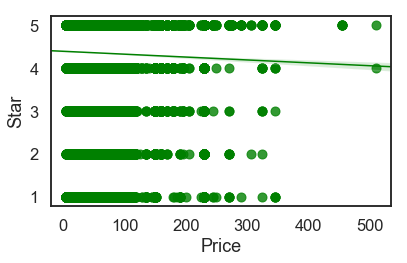

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
sns.set(palette='pastel')
sns.set_context('talk', rc = {'lines.linewidth': 1})
sns.set_style('white',{'font.family': 'Sans-serif', \
                            'font.Sans-serif': ['Futura']})
ax = sns.regplot(x='p_price', y='r_star', data=price_rating, color='green')
ax.set( ylabel='Star', xlabel='Price')
plt.tight_layout()
from statsmodels.formula.api import ols
import statsmodels.api as sm
lm = ols('r_star~p_price', data=price_rating,).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

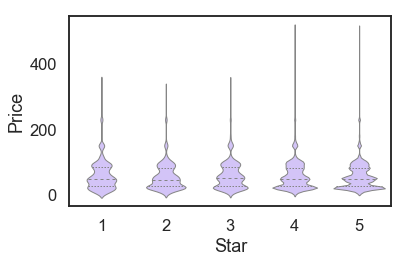

In [32]:
#distribution of product prices in product with different ratings 
ax = sns.violinplot(x='r_star', y='p_price', data=price_rating,
            inner='quartile', color='m')
ax.set( xlabel='Star', ylabel='Price')
plt.tight_layout()

There is no correlation between price and ratings.

In [33]:
#get customer with aging concern
age_filter = ['45to54', 'over54']
df_bella = df[df['r_product'].isin(bella) & ((df['c_skinconcerns'] == 'aging') | (df['c_age'].isin(age_filter)))]
df_bella['rank'] = df_bella['r_product'].apply(lambda w:bella.index(w)+1)
df_bella['machine'] = 'Bella'
df_sephora = df[df['r_product'].isin(sephora) & ((df['c_skinconcerns'] == 'aging') | (df['c_age'].isin(age_filter)))]
df_sephora['rank'] = df_sephora['r_product'].apply(lambda w:sephora.index(w)+1)
df_sephora['machine'] = 'Sephora'

In [37]:
import scipy.stats as stats
p_value = []
for r in range(1, 4):
    anova_data0 = search_results[search_results['rank'] == r]
    rs = stats.f_oneway(anova_data0[anova_data0['machine'] == 'Bella']['r_star'], 
               anova_data0[anova_data0['machine'] == 'Sephora']['r_star'])
    p = rs.pvalue
    sts = rs.statistic
    p_value.append(p)
    print('%dth product: statitics %s p-value %s' % (r, sts, p))

1th product: statitics 61.01824917288947 p-value 7.606842621971752e-14
2th product: statitics 8.285008738546756 p-value 0.004438688481007087
3th product: statitics 3.192831146665239 p-value 0.07482962309419587


In [36]:
plot_df.groupby(['rank', 'machine'])['r_star'].mean()

rank  machine
1     Bella      4.595960
      Sephora    3.582090
2     Bella      4.954545
      Sephora    4.554839
3     Bella      4.860000
      Sephora    4.752475
Name: r_star, dtype: float64

['p_value:0.0', 'p_value:0.0', 'p_value:0.07']


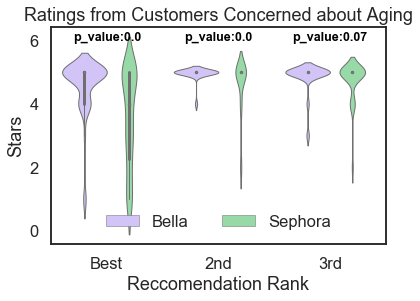

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

search_results = pd.concat([df_bella, df_sephora])
plot_df = search_results[search_results['rank'] < 6]
r_dic = {1:'Best', 2:'2nd', 3:'3rd'}
plot_df['Rank'] = plot_df['rank'].apply(lambda r: r_dic[r])
medians = plot_df.groupby(['machine'])['r_star'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]
pvalue_labels = [np.round(p, 2) for p in p_value]
pvalue_labels = ['p_value:' + str(p) for p in pvalue_labels]
print(pvalue_labels)

plt.figure()
sns.set(palette='pastel')
sns.set_context('talk', rc = {'lines.linewidth': 1, 'figure.figsize': (20,5)})
sns.set_style('white',{'font.family': 'Sans-serif', \
                            'font.Sans-serif': ['Futura']})
ax = sns.violinplot(x='Rank', y='r_star',
            hue='machine', data=plot_df,
            palette=['m', 'g'],
            inner='box',
            order=['Best', '2nd', '3rd']
            )

ax.legend(frameon=False, loc='lower center', ncol=2)
ax.set( ylabel='Stars',
        xlabel='Reccomendation Rank',
        title='Ratings from Customers Concerned about Aging')
pos = range(len(pvalue_labels))

for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 6, pvalue_labels[tick], 
            horizontalalignment='center', size='x-small', color='black', weight='semibold')

In [43]:
anova_data = search_results[search_results['rank'] < 4]
print(anova_data.groupby('machine')['r_star'].mean())
stats.f_oneway(anova_data[anova_data['machine'] == 'Bella']['r_star'], 
               anova_data[anova_data['machine'] == 'Sephora']['r_star'])

machine
Bella      4.762195
Sephora    4.271795
Name: r_star, dtype: float64


F_onewayResult(statistic=59.45639393099498, pvalue=3.377294829820281e-14)

In [29]:
#df.shape[0]  == reviews.shape[0]
print(customers.shape)
print(df_bella.shape)
print(df_sephora.shape)

(20866, 7)
(171, 15)
(382, 15)


In [3]:
fp = './bella/bellaflask/tmp/review_sentiment.df.pk'
with open(fp, 'rb') as f:
     review_df = pickle.load(f)
fp = './bella/bellaflask/tmp/product_info.df.pk'
with open(fp, 'rb') as f:
     product_df = pickle.load(f)

In [5]:
df = pd.merge(review_df, product_df, left_on='r_product', right_on='p_ID', how='left')

In [6]:
print(review_df.shape)
print(product_df.shape)
print(df.shape)

(102353, 6)
(365, 10)
(102353, 16)


In [11]:
filename = './bella/bellaflask/tmp/review_sentiment_product_info.df.pk'
with open(filename, 'wb') as f:
     pickle.dump(df, f)

In [12]:
fp = './bella/bellaflask/tmp/product_info.df.pk'
with open(fp, 'wb') as f:
     pickle.dump(product_df, f)

In [23]:
cache0 = product_df[product_df['p_ID'].isin(['P433970', 'P411254', 'P3550'])][['p_Brand', 
                                                                               'p_Name',
                                                                               'p_function', 
                                                                               'p_link', 
                                                                               'p_image']]
cache0.to_dict('records')

[{'p_Brand': 'Lancer',
  'p_Name': 'Advanced Retinol Treatment',
  'p_function': '- Fine lines and wrinkles- Dullness and uneven texture- Loss of firmness and elasticity',
  'p_image': 'https://www.sephora.com/productimages/sku/s2126001-main-grid.jpg',
  'p_link': 'https://www.sephora.com/product/advanced-retinol-treatment-P433970'},
 {'p_Brand': 'Dr. Brandt Skincare',
  'p_Name': 'MAGNETIGHT Age-Defier Mask',
  'p_function': ' - Dullness and uneven texture - Loss of firmness and elasticity ',
  'p_image': 'https://www.sephora.com/productimages/sku/s1851898-main-grid.jpg',
  'p_link': 'https://www.sephora.com/product/magnetight-age-defier-P411254'},
 {'p_Brand': 'Peter Thomas Roth',
  'p_Name': 'AHA/BHA Acne Clearing Gel',
  'p_function': ' A potent oil-free formula that minimizes the appearance of blemishes',
  'p_image': 'https://www.sephora.com/productimages/sku/s1451038-main-grid.jpg',
  'p_link': 'https://www.sephora.com/product/aha-bha-acne-clearing-gel-P3550'}]

In [5]:
review_join = review_df
review_join['review'] = review_df['review'].map(lambda r:' '.join(r))

In [7]:
fp = './bella/bellaflask/tmp/review_sentence_sentiment.df.pk'
with open(fp, 'wb') as f:
     pickle.dump(review_join, f)